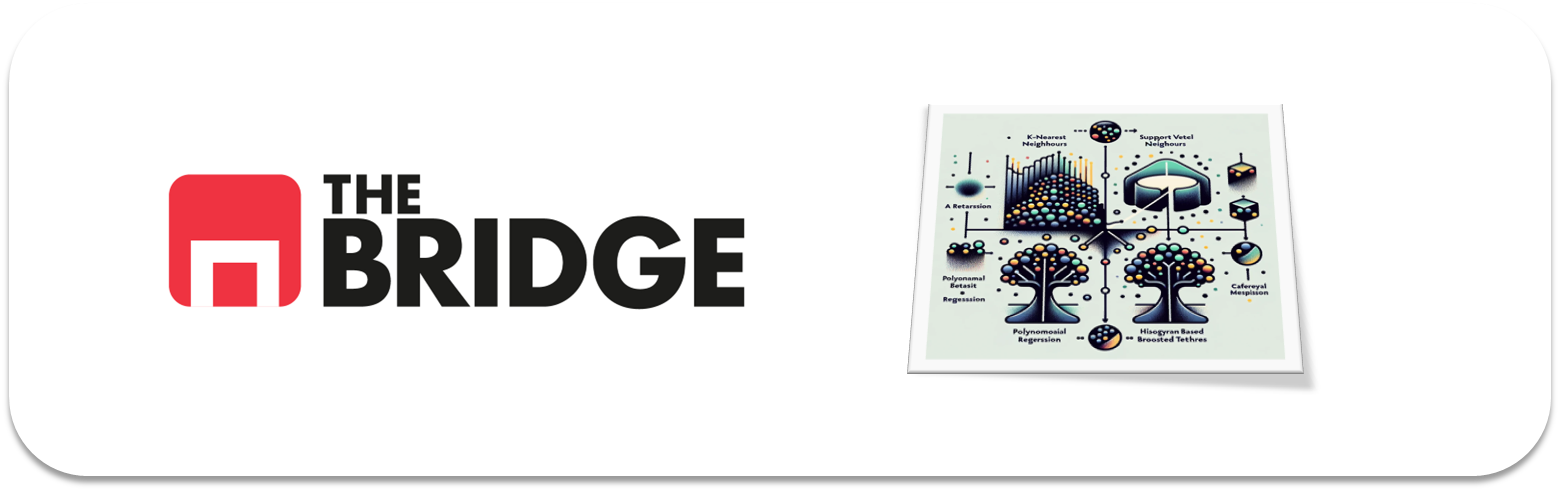

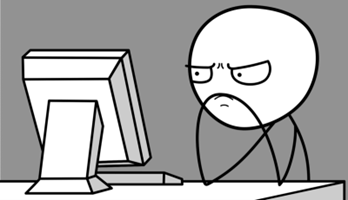

Para hacer un **repaso a los problemas de regresión con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Evaluación contra test.  
10. Análisis de errores, posibles acciones futuras.  
11. EXTRA: Persistencia del modelo en disco.  

### El problema de Negocio

El ayuntamiento de Freehold, Nueva Jersey, está preocupado por los niveles de Ozono en situaciones de contaminación. Ha adquirido unos sensores muy potentes que permiten medir la composición de la calidad del aire casi en tiempo real, pero desgraciadamente la medida de Ozono se obtiene mucho más tarde (casi 12 horas después, este dato de las horas no es relevante para el problema). Las medidas son enviadas a una plataforma central donde se quiere incorporar un modelo que en función de esas medidas pueda predecir el nivel de $O_3$ (Ozono) en el aire y establecer alarmas y umbrales para avisar a la población o tomar medidas si es necesaria.

El concejal de urbanismo y tecnología, Bruce S., os contrata para que creéis ese modelo y para ello os suministra un dataset con medidas de la calidad de aire donde han incorporado el nivel de Ozono ("PT08.S5(O3)") posteriormente. Quieren un modelo que se equivoque en media en menos de 100 unidades por millón (la medida en la que tienen registrada la presencia de Ozono).

¡Manos a la obra!

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [36]:
import bootcampviztools as bt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, mean_absolute_error


### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

Yo utilizaría el error medio abasoluto para este problema de regresión y teniendo en cuenta lo que se solicita

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [2]:
df_air=pd.read_csv("./data/air_contamination.csv")
df_air.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [3]:
df_air.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,-34.897053,1099.707856,-158.702591,10.082993,939.029205,163.732788,835.370973,56.654087,1456.143486,1022.780725,18.316054,49.232360,1.025530
std,78.202259,217.084571,140.680200,7.449640,266.829000,252.081877,256.815106,126.902274,346.204540,398.480897,8.832888,17.316389,0.403813
min,-200.000000,647.250000,-200.000000,0.149048,383.250000,-200.000000,322.000000,-200.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,0.600000,936.750000,-200.000000,4.436942,734.375000,49.000000,657.875000,52.000000,1226.625000,731.375000,11.787500,35.812500,0.736769
50%,1.500000,1063.000000,-200.000000,8.239851,909.000000,139.800000,805.500000,96.000000,1462.750000,963.250000,17.750000,49.550000,0.995395
75%,2.600000,1231.250000,-200.000000,13.988478,1116.250000,280.000000,969.250000,132.000000,1673.500000,1273.375000,24.400000,62.500001,1.313701
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,332.600000,2775.000000,2522.750000,44.600000,88.725000,2.231036


In [4]:
df_air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8991 entries, 0 to 8990
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         8991 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   NMHC(GT)       8991 non-null   int64  
 3   C6H6(GT)       8991 non-null   float64
 4   PT08.S2(NMHC)  8991 non-null   float64
 5   NOx(GT)        8991 non-null   float64
 6   PT08.S3(NOx)   8991 non-null   float64
 7   NO2(GT)        8991 non-null   float64
 8   PT08.S4(NO2)   8991 non-null   float64
 9   PT08.S5(O3)    8991 non-null   float64
 10  T              8991 non-null   float64
 11  RH             8991 non-null   float64
 12  AH             8991 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 913.3 KB


In [5]:
df_air.duplicated().value_counts()

False    8991
Name: count, dtype: int64

In [6]:
df_air.nunique() #Todas las variables son numericas discretas o continuas

CO(GT)             95
PT08.S1(CO)      3245
NMHC(GT)          428
C6H6(GT)         3772
PT08.S2(NMHC)    3772
NOx(GT)          2362
PT08.S3(NOx)     3518
NO2(GT)          1367
PT08.S4(NO2)     4407
PT08.S5(O3)      4678
T                3367
RH               4902
AH               8987
dtype: int64

In [7]:
target= "PT08.S5(O3)"

### Ejercicio 3: Split

Haz el split en train y test.

In [8]:
train_set,test_set=train_test_split(df_air,test_size=0.2,random_state=42)
print(train_set.shape)
print(test_set.shape)

(7192, 13)
(1799, 13)


### Ejercicio 4: MiniEDA (I)

Analiza la distribución del target brevemente.

<Axes: xlabel='PT08.S5(O3)', ylabel='Count'>

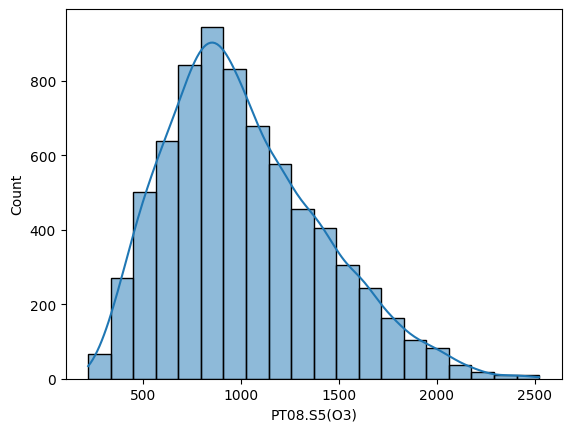

In [9]:
sns.histplot(train_set[target],kde=True,bins=20)

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, para las numéricas analiza la correlación numéricamente y gráficamente, para las categóricas analiza la distribución del target para cada valor de la categórica.

In [10]:
correlaciones=train_set.corr()
correlaciones

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.000000,0.122506,0.129424,0.075437,0.083927,0.537019,-0.088243,0.676250,-0.054931,0.128110,-0.125947,-0.019473,-0.178433
PT08.S1(CO),0.122506,1.000000,0.243351,0.884962,0.893618,0.567169,-0.771052,0.312481,0.679732,0.901005,0.044293,0.117609,0.131040
NMHC(GT),0.129424,0.243351,1.000000,0.132976,0.129683,0.000752,0.053649,0.105388,0.207487,0.110077,-0.068982,-0.016271,-0.125931
C6H6(GT),0.075437,0.884962,0.132976,1.000000,0.981825,0.538124,-0.733903,0.264477,0.764999,0.864269,0.193377,-0.053293,0.167025
PT08.S2(NMHC),0.083927,0.893618,0.129683,0.981825,1.000000,0.535406,-0.795214,0.284718,0.776315,0.879959,0.236493,-0.083230,0.185433
NOx(GT),0.537019,0.567169,0.000752,0.538124,0.535406,1.000000,-0.504951,0.821307,0.145186,0.623100,-0.244188,0.122632,-0.203319
PT08.S3(NOx),-0.088243,-0.771052,0.053649,-0.733903,-0.795214,-0.504951,1.000000,-0.289655,-0.537843,-0.794185,-0.144771,-0.057839,-0.230914
NO2(GT),0.676250,0.312481,0.105388,0.264477,0.284718,0.821307,-0.289655,1.000000,0.022972,0.337581,-0.139848,-0.077195,-0.250775
PT08.S4(NO2),-0.054931,0.679732,0.207487,0.764999,0.776315,0.145186,-0.537843,0.022972,1.000000,0.590688,0.559257,-0.029198,0.629302
PT08.S5(O3),0.128110,0.901005,0.110077,0.864269,0.879959,0.623100,-0.794185,0.337581,0.590688,1.000000,-0.032899,0.133955,0.069113


<Axes: >

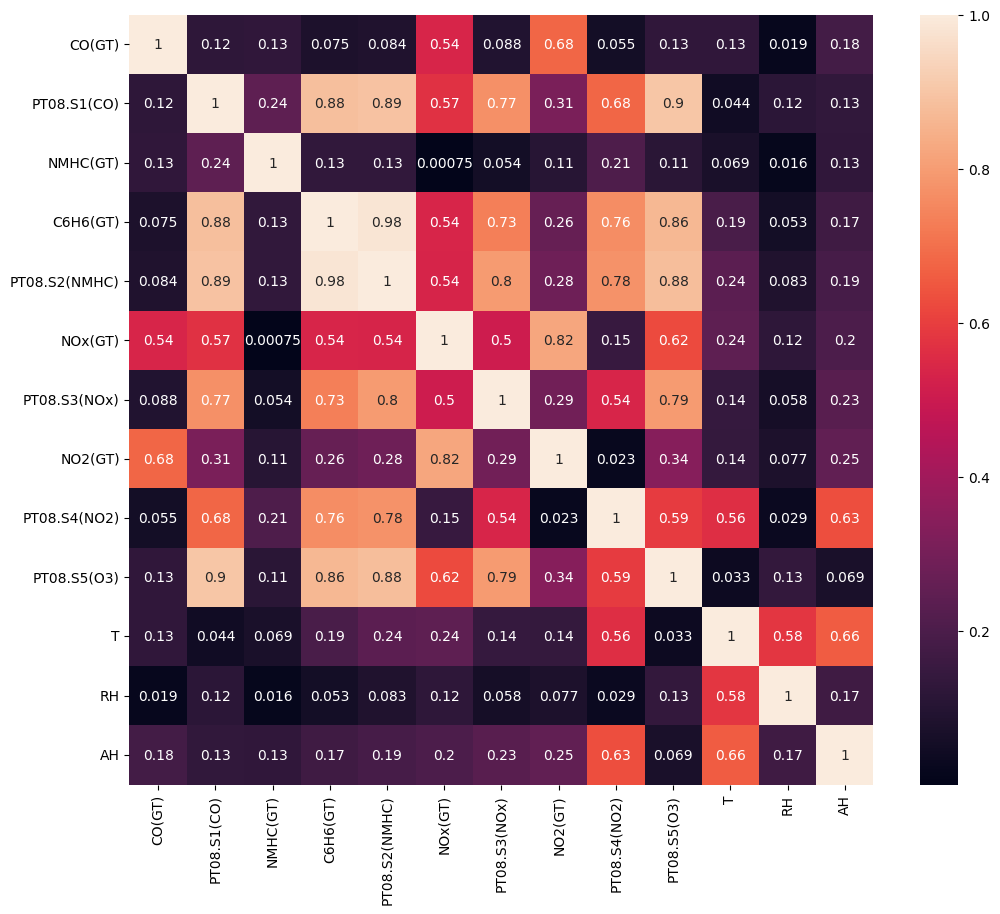

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(np.abs(correlaciones),annot=True)

In [12]:
#Tras el examen de las correlaciones voy a poner el umbral en un 5% de correlacion minima y por lo tanto descarto "T" 

In [13]:
#Analisis de colinealidad umbral 0.85

correlaciones_sin_target=train_set.drop(columns=target).corr()

pares_correlados = []

for i in range(len(correlaciones_sin_target.columns)):
    for j in range(i + 1, len(correlaciones_sin_target.columns)):  # Evitar duplicados y diagonales
        if abs(correlaciones_sin_target.iloc[i, j]) > 0.85:  # Comprobar correlación absoluta
            pares_correlados.append((
                correlaciones_sin_target.columns[i],  # Columna 1
                correlaciones_sin_target.columns[j],  # Columna 2
                correlaciones_sin_target.iloc[i, j]   # Valor de correlación
            ))
pd.DataFrame(pares_correlados, columns=["Columna 1", "Columna 2", "Correlación"])

,Columna 1,Columna 2,Correlación
0,PT08.S1(CO),C6H6(GT),0.884962
1,PT08.S1(CO),PT08.S2(NMHC),0.893618
2,C6H6(GT),PT08.S2(NMHC),0.981825


In [14]:
pares_correlados

[('PT08.S1(CO)', 'C6H6(GT)', 0.8849615905270112),
 ('PT08.S1(CO)', 'PT08.S2(NMHC)', 0.893617834782422),
 ('C6H6(GT)', 'PT08.S2(NMHC)', 0.9818250997811474)]

In [15]:
#Son tres variables que estan excesivamente correladas entre si, voy a ver de nuevo su correlacion con el target y quien tenga mayor se quedará
train_set[['PT08.S1(CO)', 'C6H6(GT)','PT08.S2(NMHC)',target]].corr()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S5(O3)
PT08.S1(CO),1.000000,0.884962,0.893618,0.901005
C6H6(GT),0.884962,1.000000,0.981825,0.864269
PT08.S2(NMHC),0.893618,0.981825,1.000000,0.879959
PT08.S5(O3),0.901005,0.864269,0.879959,1.000000


In [16]:
# Me quedo entonces con 'PT08.S1(CO)' y elimino 'C6H6(GT)' y 'PT08.S2(NMHC)'
features_descartadas= ['T', 'C6H6(GT)','PT08.S2(NMHC)']

### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

In [17]:
#Quito las variables descartadas
features_num=train_set.columns.to_list()
for i in features_descartadas:
    features_num.remove(i)
features_num.remove(target)
features_num

['CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'RH',
 'AH']

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


lm = LinearRegression()  
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)  
lgbm = LGBMRegressor(n_estimators=100, max_depth=5, random_state=42)  
cat = CatBoostRegressor(iterations=100, depth=5, verbose=0, random_seed=42)  

modelos = {
    "Linear Regression": lm,
    "Random Forest": rf,
    "LightGBM": lgbm,
    "CatBoost": cat,
}

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

array([[<Axes: title={'center': 'CO(GT)'}>,
        <Axes: title={'center': 'PT08.S1(CO)'}>,
        <Axes: title={'center': 'NMHC(GT)'}>],
       [<Axes: title={'center': 'NOx(GT)'}>,
        <Axes: title={'center': 'PT08.S3(NOx)'}>,
        <Axes: title={'center': 'NO2(GT)'}>],
       [<Axes: title={'center': 'PT08.S4(NO2)'}>,
        <Axes: title={'center': 'RH'}>, <Axes: title={'center': 'AH'}>]],
      dtype=object)

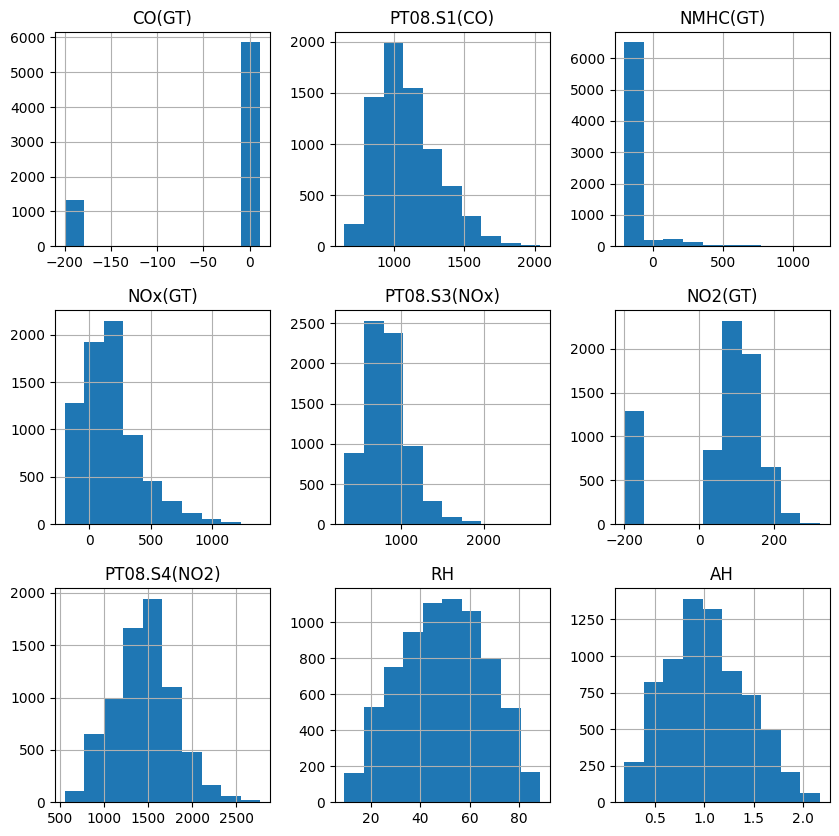

In [19]:
train_set[features_num].hist(figsize=(10,10))

In [20]:
features_num

['CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'RH',
 'AH']

array([[<Axes: title={'center': 'CO(GT)'}>,
        <Axes: title={'center': 'PT08.S1(CO)'}>],
       [<Axes: title={'center': 'NMHC(GT)'}>,
        <Axes: title={'center': 'NOx(GT)'}>],
       [<Axes: title={'center': 'PT08.S3(NOx)'}>,
        <Axes: title={'center': 'NO2(GT)'}>]], dtype=object)

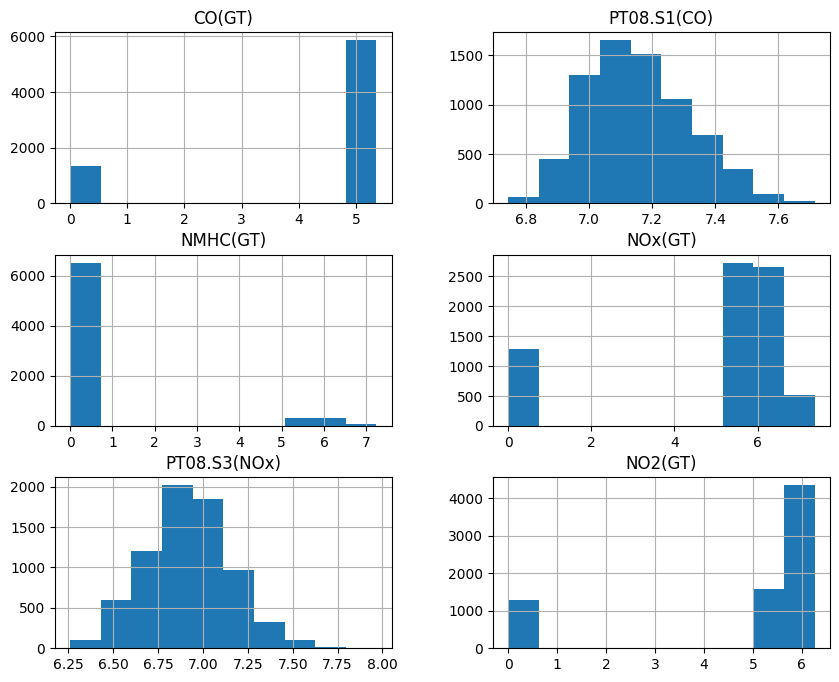

In [21]:
features_log = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)']

minimo = train_set[features_log].min().min()
ajuste = abs(minimo) + 1 if minimo <= 0 else 0

# Aplicar transformación logarítmica con el ajuste
for i in features_log:
    train_set[i] = np.log(train_set[i] + ajuste)
    test_set[i] = np.log(test_set[i] + ajuste)

train_set[features_log].hist(figsize=(10, 8))

In [22]:
#Ahora escalo todas las variables numericas creando un nuevo set que usare para entrenar Linear regression

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_set_scaled= train_set.copy()
test_set_scaled= test_set.copy()
train_set_scaled[features_num] = scaler.fit_transform(train_set[features_num])
test_set_scaled[features_num] = scaler.transform(test_set[features_num])

In [23]:
train_set.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000,7192.000000
mean,4.327394,7.155050,0.566940,9.996265,935.740255,4.933258,6.917699,4.707904,1454.166956,1017.120643,18.347794,49.253558,1.027951
std,2.066149,0.161677,1.749498,7.413889,266.308898,2.327518,0.238114,2.201185,344.351668,397.817754,8.827794,17.260384,0.403272
min,0.000000,6.743175,0.000000,0.149048,383.250000,0.000000,6.259581,0.000000,551.000000,221.000000,-1.900000,9.175000,0.184679
25%,5.306286,7.033727,0.000000,4.372234,730.937500,5.513429,6.759545,5.529429,1226.687500,725.187500,11.825000,35.800001,0.738636
50%,5.310246,7.139065,0.000000,8.144817,905.125000,5.826000,6.916591,5.690359,1462.250000,954.375000,17.775000,49.575000,0.997302
75%,5.315666,7.263154,0.000000,13.806061,1110.312500,6.175867,7.069023,5.805135,1668.250000,1268.062500,24.406250,62.574999,1.313524
max,5.358942,7.714566,7.237059,63.741476,2214.000000,7.371489,7.966847,6.258816,2775.000000,2522.250000,44.600000,88.725000,2.176616


In [24]:
train_set_scaled.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7.192000e+03,7.192000e+03,7.192000e+03,7192.000000,7192.000000,7.192000e+03,7.192000e+03,7.192000e+03,7.192000e+03,7192.000000,7192.000000,7.192000e+03,7.192000e+03
mean,-8.595275e-17,-1.255701e-15,7.903701e-18,9.996265,935.740255,3.141721e-16,3.173336e-15,1.867249e-16,-1.289291e-16,1017.120643,18.347794,-1.012662e-16,-4.001249e-17
std,1.000070e+00,1.000070e+00,1.000070e+00,7.413889,266.308898,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,397.817754,8.827794,1.000070e+00,1.000070e+00
min,-2.094570e+00,-2.547696e+00,-3.240811e-01,0.149048,383.250000,-2.119684e+00,-2.764072e+00,-2.138953e+00,-2.622986e+00,221.000000,-1.900000,-2.322158e+00,-2.091219e+00
25%,4.738085e-01,-7.504580e-01,-3.240811e-01,4.372234,730.937500,2.492832e-01,-6.642395e-01,3.732456e-01,-6.606481e-01,725.187500,11.825000,-7.795014e-01,-7.174694e-01
50%,4.757255e-01,-9.887548e-02,-3.240811e-01,8.144817,905.125000,3.835865e-01,-4.651753e-03,4.463615e-01,2.347486e-02,954.375000,17.775000,1.862437e-02,-7.600439e-02
75%,4.783489e-01,6.686906e-01,-3.240811e-01,13.806061,1110.312500,5.339146e-01,6.355592e-01,4.985078e-01,6.217421e-01,1268.062500,24.406250,7.718465e-01,7.081898e-01
max,4.992956e-01,3.460945e+00,3.812856e+00,63.741476,2214.000000,1.047640e+00,4.406389e+00,7.046299e-01,3.835976e+00,2522.250000,44.600000,2.286982e+00,2.848562e+00


### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [25]:
X_train= train_set[features_num]
y_train= train_set[target]

In [26]:
X_test= test_set[features_num]
y_test= test_set[target]

In [27]:
X_train_scaled = train_set_scaled[features_num]
X_test_scaled = test_set_scaled[features_num]

### Ejercicios 9:

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. 

In [28]:
print(modelos)

{'Linear Regression': LinearRegression(), 'Random Forest': RandomForestRegressor(max_depth=5, random_state=42), 'LightGBM': LGBMRegressor(max_depth=5, random_state=42), 'CatBoost': <catboost.core.CatBoostRegressor object at 0x000002DDA2F7D710>}


### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea "mean_absolute_error" (recuerda el funcionamiento del scoring en "sklearn", no te valdrá poner "mean_absolute_error"). Escoge el modelo ganador.

In [29]:
metricas_cv = {}
valores = []
for nombre,modelo in modelos.items():
    print(modelo)
    if nombre == "Linear Regression":
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv=5, scoring="neg_mean_absolute_error")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "neg_mean_absolute_error")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmin(valores)]

LinearRegression()
RandomForestRegressor(max_depth=5, random_state=42)
LGBMRegressor(max_depth=5, random_state=42)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2036
[LightGBM] [Info] Number of data points in the train set: 5753, number of used features: 9
[LightGBM] [Info] Start training from score 1019.094516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

c:\Users\Guillermo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\Guillermo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklea

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 5754, number of used features: 9
[LightGBM] [Info] Start training from score 1019.772767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\Guillermo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [30]:
for nombre, valores in metricas_cv.items():
    print(f"Modelo <{nombre}>, Error Absoluto Medio: {-np.mean(valores)}")
print(f"El ganador es {ganador}")

Modelo <Linear Regression>, Error Absoluto Medio: 112.90639202898906
Modelo <Random Forest>, Error Absoluto Medio: 107.41534868989922
Modelo <LightGBM>, Error Absoluto Medio: 83.43379455348004
Modelo <CatBoost>, Error Absoluto Medio: 84.11854418241116
El ganador es Linear Regression


### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "mean absolute error". 

In [32]:
param_grid = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [None, 5, 10],
    "num_leaves": [31, 15, 50],
    "min_child_samples": [20, 10, 50],
}

lgbm_grid = LGBMRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=lgbm_grid,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

c:\Users\Guillermo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2097
[LightGBM] [Info] Number of data points in the train set: 7192, number of used features: 9
[LightGBM] [Info] Start training from score 1017.120643


c:\Users\Guillermo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [None, 5, 10],
                         'min_child_samples': [20, 10, 50],
                         'n_estimators': [100, 300, 500],
                         'num_leaves': [31, 15, 50]},
             scoring='neg_mean_absolute_error', verbose=1)

In [33]:
-grid_search.best_score_

75.22977397050222

In [34]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': None,
 'min_child_samples': 10,
 'n_estimators': 500,
 'num_leaves': 50}

In [35]:
lgbm_optimizado= grid_search.best_estimator_

### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

In [37]:
lgbm_opt_predict=lgbm_optimizado.predict(X_test)
mean_absolute_error(y_test,lgbm_opt_predict)

72.93551240891118

In [39]:
#El Hospital aceptaría este modelo dado que cumple su objetivo

### Ejercicio 13: Análisis de errores

Comparar los valores predichos contra los reales mediante una gráfica (puedes emplear la función que empleamos en el workout de la unidad anterior). Haz un pequeño análisis.

In [40]:
def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()

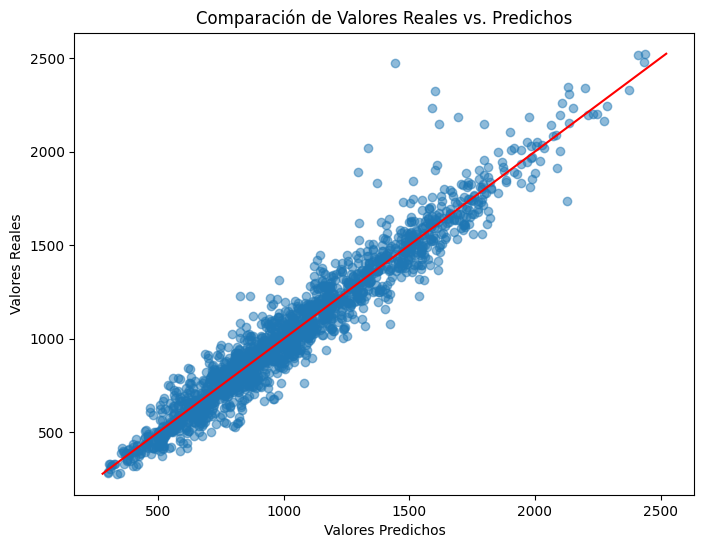

In [41]:
plot_predictions_vs_actual(y_test,lgbm_opt_predict)

In [ ]:
#Nuestro modelo predice de manera muy ajustada a los valores reales

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/o3_pred" con la extesión apropiada.

In [42]:
import pickle

with open("./models/o3_pred.pkl", "wb") as modelo_file:
    pickle.dump(lgbm_optimizado, modelo_file)

print("Modelo guardado con éxito usando pickle.")

Modelo guardado con éxito usando pickle.
